In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import joblib 
import requests
import os

# Function

In [2]:
def get_vn30f(start_time, now_time, symbol):
    def vn30f():
            return requests.get(f"https://services.entrade.com.vn/chart-api/chart?from={start_time}&resolution=1&symbol={symbol}&to={now_time}").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    ohlc_dict = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    dt_object = datetime.utcfromtimestamp(start_time) + timedelta(hours = 7)
    now_object = datetime.utcfromtimestamp(now_time) + timedelta(hours = 7)

    print(f'===> Data {symbol} from {dt_object} to {now_object} has been appended ')

    return vn30fm

In [3]:
def choose_position(roi, trade_threshold = 0.01):
    pos =0
    # Predict position base on change in future
    if roi > trade_threshold:
        pos = 1
    elif roi < -trade_threshold:
        pos = -1
    else:
        pos = 0

    return pos

def backtest_position_ps(position, price, periods, percentage=0.01):
    #print(periods)
    # Shift positions to align with future price changes and handle NaN by filling with 0
    pos = pd.Series(position, index=pd.Series(price).index).shift(1).fillna(0)
    pos = pd.Series(pos).rolling(int(periods)).sum() #pos for 10 hour predict

    price_array = pd.Series(price).shift(1).fillna(0)

    pos_diff = pos.diff()
    fee = pos_diff*price_array*0.05*percentage

    # Calculate price changes over the given periods
    ch = pd.Series(price) - price_array

    # Calculate total PnL
    total_pnl = pos*ch - fee
    return total_pnl

def calculate_sharpe_ratio(pnl):
    pnl = np.diff(pnl)
    std = np.std(pnl) if np.std(pnl) != 0 else 0.001
    sharpe = np.mean(pnl)/std*np.sqrt(252)
    return sharpe

def sharpe_for_vn30f(y_pred, y_price, trade_threshold, fee_perc, periods):

    # Predict position base on change in future
    pos = [choose_position(roi, trade_threshold) for roi in y_pred]
    pos = np.array(pos)

    # Calculate PNL
    pnl = backtest_position_ps(pos, y_price, percentage=fee_perc, periods=periods)
    pnl = np.cumsum(pnl)

    # Standardalize PNL to date
    daily_pnl = [pnl.iloc[i] for i in range(0, len(pnl), 241)]
    daily_pnl = pd.Series(daily_pnl).fillna(0)

    # Calculate Sharpe
    sharpe = calculate_sharpe_ratio(daily_pnl)

    return pos, pnl, daily_pnl, sharpe

def calculate_hitrate(pos_predict, pos_true):
    if len(pos_predict) != len(pos_true):
        raise ValueError("Độ dài của hai mảng không khớp")

    # Tính số lượng dự đoán đúng (các phần tử tương ứng giống nhau)
    correct_predictions = np.sum(pos_predict == pos_true)

    # Tính tỷ lệ hit rate
    hit_rate_value = correct_predictions / len(pos_predict)

    return hit_rate_value

def scale_data(data):
    scaler = StandardScaler()
    data = np.where(np.isinf(data), np.nan, data)
    data = pd.DataFrame(data)
    data = data.fillna(0)
    scaler.fit(data)
    data=pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

    return data

def split_data(data):
    new_part = np.array_split(data, 3)

    # Access each part individually
    hold_out = new_part[2]
    train_data = pd.concat([new_part[0], new_part[1]], axis=0)

    return train_data, hold_out

def split_optuna_data(data):
        train_data, _ = split_data(data)
        optuna_data = train_data.drop(['close', 'open','high','low','volume', 'Return'], axis=1)
        optuna_data = scale_data(optuna_data)
        X_train, X_valid, y_train, y_valid = train_test_split(optuna_data, train_data['Return'], test_size=0.5, shuffle=False)

        return X_train, X_valid, y_train, y_valid

def return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl):
    result = pd.DataFrame()
    result['Close_Holdout'] = hold_out['Close']
    result['Ground_value_Holdout'] = hold_out['Return']
    result['Predict_diff_Holdout'] = pd.Series(y_hold_out, index=data.index[len(train_data):len(data)])
    result['Position_predict_Holdout'] = pd.Series(pos, index=data.index[len(train_data):len(data)])
    result['PNL_Holdout'] = pd.Series(pnl)
    return result


# Get data

In [4]:
df = pd.read_csv('save_data.csv')

In [5]:
now_time = 9999999999
symbol = 'VN30F1M'
last_time_str = ""
for i in range(len(df) - 1, -1, -1):
    if pd.notna(df.iloc[i]['Date']):
        last_time_str = df.iloc[i]['Date'] + ' ' + df.iloc[i]['time']
        break
last_time = datetime.strptime(str(last_time_str), '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)

exact_last_time = last_time - timedelta(hours=7)
last_time_num = int(exact_last_time.timestamp()-60)
# print(f'check nextime {exact_last_time} {type(exact_last_time)}')
# print(f'check now {now} {type(now)}')
# print(df.head())

# Append vào dữ liệu cũ
new_data = get_vn30f(last_time_num, now_time, symbol)

===> Data VN30F1M from 2024-06-24 14:44:00 to 2286-11-21 00:46:39 has been appended 


In [6]:
new_data

,Date,Open,High,Low,Close,Volume
0,2024-06-24 14:45:00,1290.7,1290.7,1290.7,1290.7,7478
1,2024-06-25 09:00:00,1293.9,1294.0,1293.3,1293.7,2915
2,2024-06-25 09:01:00,1293.7,1293.7,1292.5,1292.8,1531
3,2024-06-25 09:02:00,1292.9,1292.9,1292.3,1292.8,906
4,2024-06-25 09:03:00,1292.5,1292.6,1291.6,1292.3,1031
...,...,...,...,...,...,...
2669,2024-07-09 14:27:00,1319.3,1319.3,1318.5,1318.8,626
2670,2024-07-09 14:28:00,1318.6,1319.7,1318.5,1319.5,1409
2671,2024-07-09 14:29:00,1319.7,1319.8,1319.4,1319.5,1758
2672,2024-07-09 14:30:00,1319.4,1319.4,1319.4,1319.4,20


# Choose model

In [7]:
with open('top_10_list.pkl', 'rb') as f:
    selected_columns_cluster = pickle.load(f)
feat = selected_columns_cluster[0].columns # Chosen features which fit with my model

selected_columns_cluster[0].columns

Index(['volatility_bbli', 'volatility_kcw', 'trend_adx', 'volume_adi',
       'volatility_kcp', 'trend_psar_down_indicator', 'momentum_pvo_hist',
       'volatility_bbhi', 'trend_psar_up_indicator', 'trend_mass_index'],
      dtype='object')

In [8]:
xbg_reg = xgb.XGBRegressor()
xbg_reg.load_model(f"best_in_cluster_0.json")

# Add feature

In [9]:
from ta import add_all_ta_features
import pandas_ta as ta

In [21]:
def z_score_rolling(series, window=30):
    """Tính Z-score rolling"""
    mean = series.rolling(window).mean()
    std = series.rolling(window).std(ddof=0)
    z_score = (series - mean) / std
    return z_score

def generate_features(data, shift=1):
    """
    Hàm này tạo ra các features mới từ dữ liệu cổ phiếu.

    Args:
    df (pandas.DataFrame): DataFrame chứa dữ liệu cần tạo features, có các cột 'open', 'high', 'low', 'close' và 'volume'.

    Returns:
    pandas.DataFrame: DataFrame đã được mở rộng với các features mới.
    """
    df = data.copy()
    # Thêm tất cả các đặc trưng kỹ thuật từ thư viện TA-Lib
    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']

    # RSI
    df['RSI'] = ta.rsi(df['Close'], length=14)

    # MACD
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_Signal'] = macd['MACDs_12_26_9']
    df['MACD_Hist'] = macd['MACDh_12_26_9']

    # Stochastic Oscillator
    stoch = ta.stoch(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch['STOCHk_14_3_3']
    df['Stoch_D'] = stoch['STOCHd_14_3_3']

    # ATR
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

    # Z-score rolling
    df['Z_Score_Rolling'] = z_score_rolling(df['Close'], window=30)

    # Percent Change 5 minutes
    df['Trend_5min'] = df['Close'].pct_change(periods=5)

    # Rolling Standard Deviation 30 minutes
    df['Std_Rolling_30min'] = df['Close'].rolling(window=30).std()

    # Difference between Close and 30 minutes Moving Average
    ma_30min = df['Close'].rolling(window=30).mean()
    df['Close_Minus_MA_30min'] = df['Close'] - ma_30min

    # Simple Moving Average 10 minutes
    df['SMA_10'] = df['Close'].rolling(window=10).mean()

    df_ta = df.copy()
    df_ta.ta.cores = 0
    df_ta.ta.strategy('common')

    cols_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date', 'time']
    df_ta = df_ta.drop(columns=cols_to_drop, errors='ignore')

    # Concatenate original dataframe with features from pandas-ta
    df = pd.concat([df, df_ta], axis=1)

    # Replace infinite values and fill NaN values with 0
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    df2 = data.copy()
    df2 = add_all_ta_features(df2, open="Open", high="High", low="Low", close="Close", volume="Volume")
    df2 = df2.drop(columns=['Date', 'Open','High','Low','Close','Volume'])

    df3 = pd.concat([df, df2], axis=1)

    return df3

data  = generate_features(new_data)

[X] Not an available strategy.


In [22]:
test_data = data[feat]

In [23]:
test_data

,volatility_bbli,volatility_kcw,trend_adx,volume_adi,volatility_kcp,trend_psar_down_indicator,momentum_pvo_hist,volatility_bbhi,trend_psar_up_indicator,trend_mass_index
0,0.0,NaN,0.000000,0.000000,NaN,0.0,NaN,0.0,0.0,NaN
1,0.0,NaN,0.000000,416.428571,2.666667,0.0,NaN,0.0,0.0,NaN
2,0.0,NaN,0.000000,-349.071429,0.771930,1.0,NaN,0.0,0.0,NaN
3,0.0,NaN,0.000000,254.928571,0.733333,0.0,NaN,0.0,1.0,NaN
4,0.0,NaN,0.000000,667.328571,0.400000,1.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2669,0.0,0.159273,14.519773,5387.784652,0.647619,0.0,-8.870751,0.0,0.0,25.771945
2670,0.0,0.160788,14.307824,6327.117985,0.970126,0.0,-6.278446,0.0,0.0,25.568556
2671,0.0,0.156234,14.190562,5448.117985,0.969256,0.0,-2.710523,0.0,0.0,25.267327
2672,0.0,0.130433,14.081675,5448.117985,0.918605,0.0,-8.704618,0.0,0.0,24.965239


# Predict

In [26]:
test_data = scale_data(test_data)

In [29]:
trade_threshold  = 0.0005
y = xbg_reg.predict(test_data)
returns = (new_data['Close'].shift(-1) - new_data['Close'])/new_data['Close']

In [30]:
pos, pnl, daily, sharpe = sharpe_for_vn30f(y, returns, trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

In [43]:
new_data['pos'] = pos
new_data['PNL'] = pnl
df_save = new_data[['Date','Close', 'pos', 'PNL']]

In [44]:
df_save

,Date,Close,pos,PNL
0,2024-06-24 14:45:00,1290.7,0,NaN
1,2024-06-25 09:00:00,1293.7,0,NaN
2,2024-06-25 09:01:00,1292.8,0,NaN
3,2024-06-25 09:02:00,1292.8,0,NaN
4,2024-06-25 09:03:00,1292.3,0,NaN
...,...,...,...,...
2669,2024-07-09 14:27:00,1318.8,0,0.007356
2670,2024-07-09 14:28:00,1319.5,0,0.004702
2671,2024-07-09 14:29:00,1319.5,0,0.004323
2672,2024-07-09 14:30:00,1319.4,0,0.008871


<Axes: >

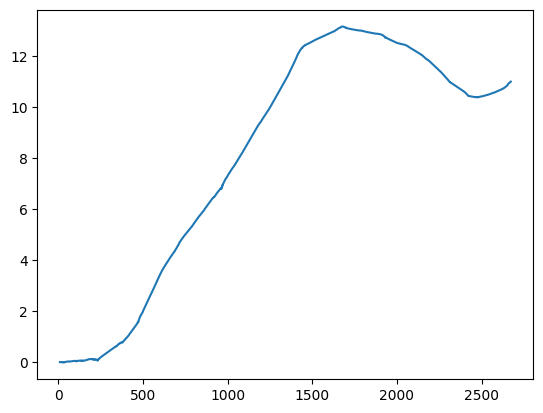

In [45]:
pnl_all = np.cumsum(pnl)
pnl_all.plot()

In [38]:
sharpe

1.139543412733894